In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

In [23]:
# Нормализация данных (важно для линейных моделей)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
# Обучение моделей (без Монте-Карло)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [26]:
def monte_carlo(model, X_train, y_train, X_test, n_iter=50):
    preds = np.zeros((n_iter, len(X_test)))
    for i in range(n_iter):
        # Bootstrap sample
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_sample, y_sample = X_train[idx], y_train[idx]
        model.fit(X_sample, y_sample)
        preds[i] = model.predict(X_test)
    return preds

In [27]:
# Ridge
ridge_mc_preds = monte_carlo(Ridge(alpha=1.0), X_train, y_train, X_test)
ridge_mean = ridge_mc_preds.mean(axis=0)
ridge_std = ridge_mc_preds.std(axis=0)

In [28]:
# XGBoost
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=100, learning_rate=0.1)
xgb_mc_preds = monte_carlo(xgb_base, X_train, y_train, X_test)
xgb_mean = xgb_mc_preds.mean(axis=0)
xgb_std = xgb_mc_preds.std(axis=0)

In [29]:
# Метрики качества
def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MSE = {mse:.4f}, R² = {r2:.4f}")

print("\nОбычные модели:")
evaluate(y_test, ridge_preds, "Ridge")
evaluate(y_test, xgb_preds, "XGBoost")

print("\nМодели с Монте-Карло:")
evaluate(y_test, ridge_mean, "Ridge MC")
evaluate(y_test, xgb_mean, "XGBoost MC")


Обычные модели:
Ridge: MSE = 0.5559, R² = 0.5758
XGBoost: MSE = 0.2952, R² = 0.7747

Модели с Монте-Карло:
Ridge MC: MSE = 0.5561, R² = 0.5756
XGBoost MC: MSE = 0.2891, R² = 0.7794


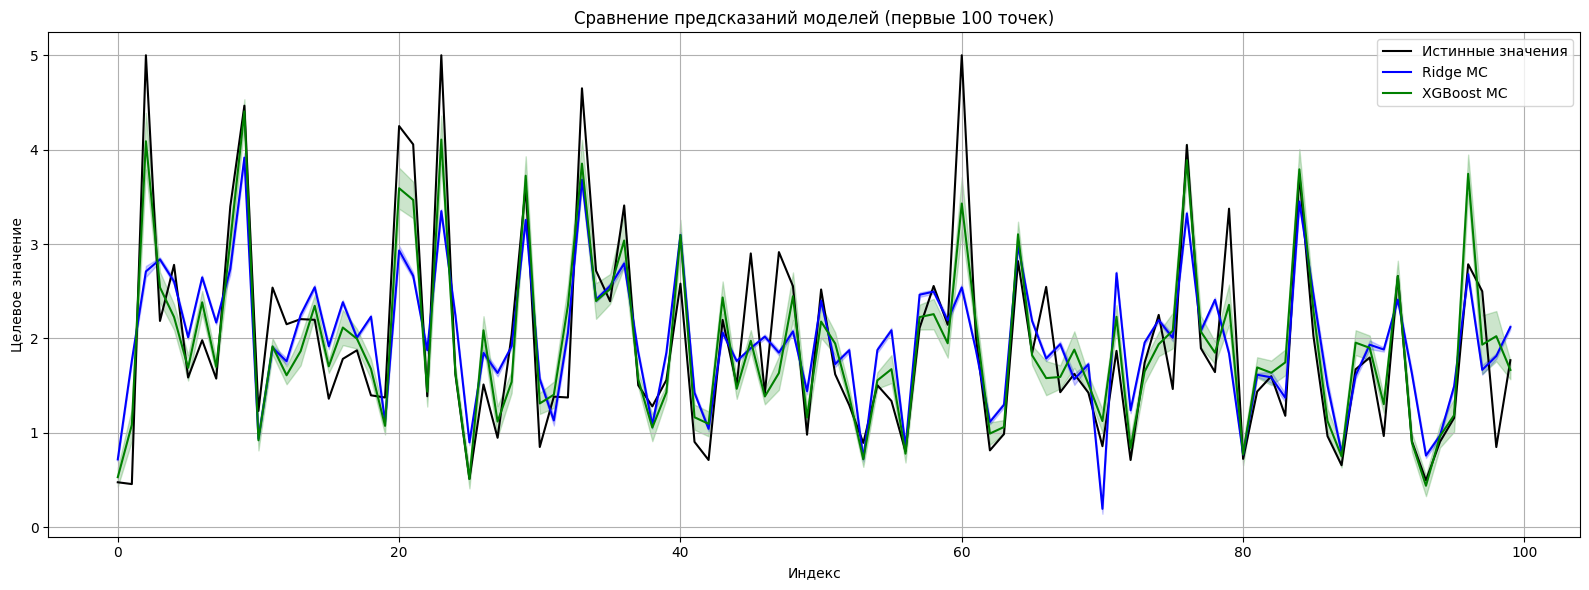

In [30]:
# Визуализация (для первых 100 точек теста)
n_points = 100
x_axis = np.arange(n_points)

plt.figure(figsize=(16, 6))
plt.plot(x_axis, y_test[:n_points], label='Истинные значения', color='black')

# Ridge
plt.plot(x_axis, ridge_mean[:n_points], label='Ridge MC', color='blue')
plt.fill_between(x_axis,
                 ridge_mean[:n_points] - 1.96 * ridge_std[:n_points],
                 ridge_mean[:n_points] + 1.96 * ridge_std[:n_points],
                 color='blue', alpha=0.2)

# XGBoost
plt.plot(x_axis, xgb_mean[:n_points], label='XGBoost MC', color='green')
plt.fill_between(x_axis,
                 xgb_mean[:n_points] - 1.96 * xgb_std[:n_points],
                 xgb_mean[:n_points] + 1.96 * xgb_std[:n_points],
                 color='green', alpha=0.2)

plt.title('Сравнение предсказаний моделей (первые 100 точек)')
plt.xlabel('Индекс')
plt.ylabel('Целевое значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

По результатам эксперимента, лучший результат по метрикам показал метод XGBoost (относительно Ridge регрессии). При обучении с Монте Карло, XGBoost улучшил метрики (Ridge регрессия улучшила незначительно).
Обычные модели:
Ridge: MSE = 0.5559, R² = 0.5758
XGBoost: MSE = 0.2952, R² = 0.7747

Модели с Монте-Карло:
Ridge MC: MSE = 0.5561, R² = 0.5756
XGBoost MC: MSE = 0.2891, R² = 0.7794